In [2]:
# =============================
# 🔥 PyTorch
# =============================
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms

# =============================
# 📊 data process
# =============================
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# =============================
# 🧠 ML
# =============================
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize

# =============================
# 🖼️ OpenCV
# =============================
import cv2

In [3]:
# check device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device("mps" if torch.backends.mps.is_available() else device)

print(device)

mps


In [4]:
# prepare dataset
trainDataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=True,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

testDataset = torchvision.datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)

# Confirm they are in grayscale (they should already be).
# should be [1, 28, 28], 1 channel, 28x28 pixels (grayscale)
train_loader = torch.utils.data.DataLoader(
    trainDataset, batch_size=64, shuffle=True, num_workers=2, drop_last=True)
test_loader = torch.utils.data.DataLoader(
    testDataset, batch_size=64, shuffle=True, num_workers=2, drop_last=True)

print(trainDataset[0][0].shape)
print(testDataset[0][1])

torch.Size([1, 28, 28])
9


In [5]:
# clean up the data
# go through the dataset and remove all the images that has different shape
shape = trainDataset[0][0].shape
print(f"shape: {shape}")
to_remove = []

for i in tqdm(range(len(trainDataset))):
    if trainDataset[i][0].shape != shape:
        to_remove.append(i)
print(f"removing {len(to_remove)} images from the training dataset")
        
for i in tqdm(range(len(testDataset))):
    if testDataset[i][0].shape != shape:
        to_remove.append(i)
print(f"removing {len(to_remove)} images from the test dataset")

shape: torch.Size([1, 28, 28])


100%|██████████| 60000/60000 [00:01<00:00, 47297.91it/s]


removing 0 images from the training dataset


100%|██████████| 10000/10000 [00:00<00:00, 47811.69it/s]

removing 0 images from the test dataset


In [6]:
def siftFeatureDetector(image):
    try:
        sift = cv2.SIFT_create()

        image_np = image.numpy()
        image_np = np.transpose(image_np, (1, 2, 0))
        if image_np.max() <= 1.0:
            image_np = (image_np * 255).astype('uint8')
    
        _, descriptors = sift.detectAndCompute(image_np, None)

        if descriptors is None or descriptors.shape[0] == 0:
            return np.array([])
        return descriptors
    except:
        print(f"Error in SIFT, image shape: {image.shape}")
        return np.array([])

In [7]:
def extraDescriptorsAndLabel(data):
    descriptors = siftFeatureDetector(data[0])
    return descriptors, data[1]

In [8]:
def extraDescriptorsAndLabels(data_loader):
    all_descriptors = []
    all_labels = []

    # use tqdm to show progress bar
    for (data, labels) in tqdm(data_loader, desc="Processing Batches", unit="batch"):
        for item in zip(data, labels):
            descriptors, label = extraDescriptorsAndLabel(item)

            if len(descriptors) > 0:
                all_descriptors.append(descriptors)
                all_labels.append(label)

    # verify that the descriptors and the labels are being stored correctly
    if len(all_descriptors) == len(all_labels):
        all_descriptors = np.vstack(all_descriptors)
        return all_descriptors, all_labels
    else:
        print("Error: descriptors and labels are not the same length")
        return None

In [9]:
class Task1_MLP(nn.Module):
    def __init__(self, input_dim=76, hidden_dim=128, output_dim=10):
        super(Task1_MLP, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        
        return x

In [10]:
# task 1
# 1. SIFT Feature Extraction
#  1.1 Apply the SIFT feature detector to each image
print(trainDataset[12000][0].shape)
print("----------------")

train_descriptors, train_labels = extraDescriptorsAndLabels(train_loader)
test_descriptors, test_labels = extraDescriptorsAndLabels(test_loader)

torch.Size([1, 28, 28])
----------------


Processing Batches: 100%|██████████| 156/156 [00:05<00:00, 31.07batch/s]


In [11]:
#  1.2 Obtain a suitable representation of the SIFT descriptors as we learned in the class
# use the K-means clustering algorithm to cluster the descriptors
# convert the descriptors to visual words
valid_descriptors = [d for d in train_descriptors if d is not None and len(d) > 0]        
features = np.vstack(valid_descriptors)
print(f"trainnig feature shape: {features.shape}")  # (num_descriptors, 128)

trainnig feature shape: (241275, 128)


In [12]:
# this step is to determine the number of clusters, but it takes too long to run
# and cluster number is determined so we can skip this step
if 0:
    reduced_amount = 50000
    reduced_features = features[:reduced_amount]
    silhouette_scores = []
    k_values = range(100, 150)

    for k in tqdm(k_values, desc="calculate Inertia"):
        kmeans = KMeans(n_clusters=k, random_state=0)
        labels = kmeans.fit_predict(reduced_features)
        score = silhouette_score(reduced_features, labels)
        silhouette_scores.append(score)

    # draw Silhouette Score curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, silhouette_scores, marker='o', color='orange')
    plt.xlabel('k_values')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score vs. k_values')
    plt.grid(True)
    plt.show()
    # when cluster number is 116 the silhouette score is the highest

In [13]:
k_clusters = 116
k_means = KMeans(n_clusters=k_clusters, random_state=0)
k_means.fit(features)


KMeans(n_clusters=116, random_state=0)

In [14]:
sample_descriptors = np.array(valid_descriptors[0])
print(sample_descriptors)
test = k_means.predict(sample_descriptors.reshape(1, -1))
print(test)

[  1.   0.   0.   0.   0.   0.   0.   0. 142.   0.   0.   0.   0.   0.
   0.  11. 182.   1.   0.   0.   0.   1.   1.  30.  19.   2.   0.   1.
   3.   6.   3.   4.   1.   0.   0.   0.   0.   0.   0.   0. 182.   9.
   0.   0.   0.   0.   0.   3. 182.  14.   0.   0.   1.   3.   5.  35.
  27.   1.   0.   0.  33.  27.  11.  16.   1.   0.   0.   0.   0.   0.
   0.   0. 182.   2.   0.   0.   0.   0.   0.   9. 182.   9.   1.   4.
   4.   1.   0.  28.  38.   5.   2.  23.  57.   5.   1.   5.   1.   0.
   0.   0.   0.   0.   0.   0. 165.   0.   0.   0.   0.   0.   0.  13.
 182.   6.   1.   6.   6.   0.   0.  21.  25.   4.   2.  28.  27.   0.
   0.   2.]
[111]


In [15]:
def descriptors_to_vector(descriptors, kmeans_model, k_clusters):
    if descriptors is None or len(descriptors) == 0:
        return np.zeros(k_clusters)  # 如果描述符为空，返回全零向量

    features = []
    for d in descriptors:
        if d is None or len(d) == 0:
            continue
        for descriptor in d:
            features.append(d)

    cluster_labels = []
    for descriptor in descriptors:
        if descriptor is None or len(descriptor) == 0:
            continue
        cluster_labels.append(kmeans_model.predict(descriptor.reshape(1, -1)))
        
    histogram, _ = np.histogram(cluster_labels, bins=np.arange(k_clusters + 1))
    histogram = histogram / np.linalg.norm(histogram) if np.linalg.norm(histogram) != 0 else histogram
    
    return histogram

[0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.4472136 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.4472136 0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.4472136 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.4472136 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.4472136 0.
 0.        0.        0.        0.       

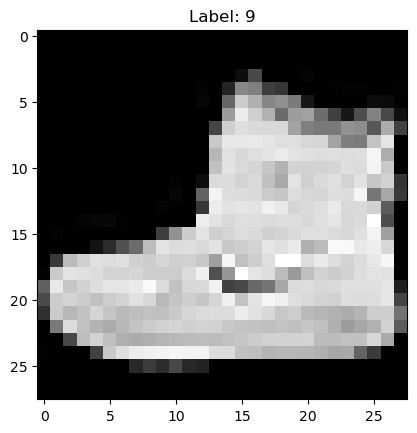

In [16]:
# print example train data
image = trainDataset[0][0].numpy().squeeze(0)
label = trainDataset[0][1]
plt.title(f"Label: {label}")
plt.imshow(image, cmap='gray')

descriptors = siftFeatureDetector(trainDataset[0][0])
vector = descriptors_to_vector(descriptors, k_means, k_clusters)
print(vector)

In [17]:
#  1.3 Document how you constructed the final feature vector (feature dimensionality, etc.).
train_vectors = []
train_labels = []
for (data, labels) in tqdm(train_loader, desc="Processing Batches", unit="batch"):
    for item in zip(data, labels):
            descriptors, label = extraDescriptorsAndLabel(item)

            train_labels.append(label)
            train_vectors.append(descriptors_to_vector(descriptors, k_means, k_clusters))

test_vectors = []
test_labels = []
for (data, labels) in tqdm(test_loader, desc="Processing Batches", unit="batch"):
    for item in zip(data, labels):
            descriptors, label = extraDescriptorsAndLabel(item)

            test_labels.append(label)
            test_vectors.append(descriptors_to_vector(descriptors, k_means, k_clusters))

# 2. MLP Training
#  2.1 MLP architecture: Use up to two hidden layers. Define the number of neurons in each layer (layer size).
#  2.2 Hyperparameter Tuning: See the next section for the list of hyperparameters to experiment with.
#  2.3 Train on the training set, evaluate on both training and testing sets.
# 3. Accuracy Reporting
#  3.1 Report and compare the training vs. testing accuracy for each experiment.

Processing Batches: 100%|██████████| 156/156 [00:08<00:00, 18.18batch/s]


In [22]:
def train(learning_rate, batch_size,  train_vectors, train_labels, test_vectors, test_labels):
    model = Task1_MLP(k_clusters)
    train_vectors = torch.tensor(train_vectors, dtype=torch.float32)
    train_labels = torch.tensor(train_labels, dtype=torch.long)
    test_vectors = torch.tensor(test_vectors, dtype=torch.float32)
    test_labels = torch.tensor(test_labels, dtype=torch.long)

    # hyperparameters
    num_epochs = 20
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_dataset = TensorDataset(train_vectors, train_labels)
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(test_vectors, test_labels)
    test_loader = DataLoader(
        test_dataset, batch_size=batch_size, shuffle=True)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()

    # loss record
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []

    # training
    for epoch in tqdm(range(num_epochs), desc="Epoch", unit="epoch"):
        model.train()
        running_loss = 0.0
        correct_train, total_train = 0, 0

        for batch_data, batch_labels in tqdm(train_loader, desc="Processing Batches", unit="batch", leave=False):
            batch_data, batch_labels = batch_data.to(
                device), batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_data.size(0)

            _, predicted = torch.max(outputs, 1)
            total_train += batch_labels.size(0)
            correct_train += (predicted == batch_labels).sum().item()

        avg_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(avg_train_loss)

        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss = 0.0
        correct_test, total_test = 0, 0
        with torch.no_grad():
            for batch_data, batch_labels in train_loader:
                batch_data, batch_labels = batch_data.to(
                    device), batch_labels.to(device)
                outputs = model(batch_data)
                loss = criterion(outputs, batch_labels)
                val_loss += loss.item() * batch_data.size(0)
                total_test += batch_labels.size(0)
                correct_test += (torch.max(outputs, 1)[1] == batch_labels).sum().item()
        
        test_accutacy = 100 * correct_test / total_test
        test_accuracies.append(test_accutacy)
        
        avg_val_loss = val_loss / len(train_loader.dataset)
        test_losses.append(avg_val_loss)

    # First Figure: Training and Validation Loss
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Validation Loss')
    plt.title("Training & Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid()
    plt.show()  # Display the first figure

    # Second Figure: Training and Validation Accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Validation Accuracy')
    plt.title("Accuracy Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.show()  # Display the second figure

    # calculate accuracy RMSE
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_data, batch_labels in tqdm(test_loader, desc="Testing Batches", unit="batch", leave=False):
            batch_data, batch_labels = batch_data.to(
                device), batch_labels.to(device)
            outputs = model(batch_data)
            _, predicted = torch.max(outputs.data, 1)
            total += batch_labels.size(0)
            correct += (predicted == batch_labels).sum().item()

    print(f"Accuracy: {100 * correct / total:.2f}%")
    print(f"RMSE: {np.sqrt(np.mean(np.array(test_losses))):.4f}")
    print(f"RAE : {np.mean(np.array(test_losses)):.4f}")

Epoch: 100%|██████████| 20/20 [05:22<00:00, 16.13s/epoch]


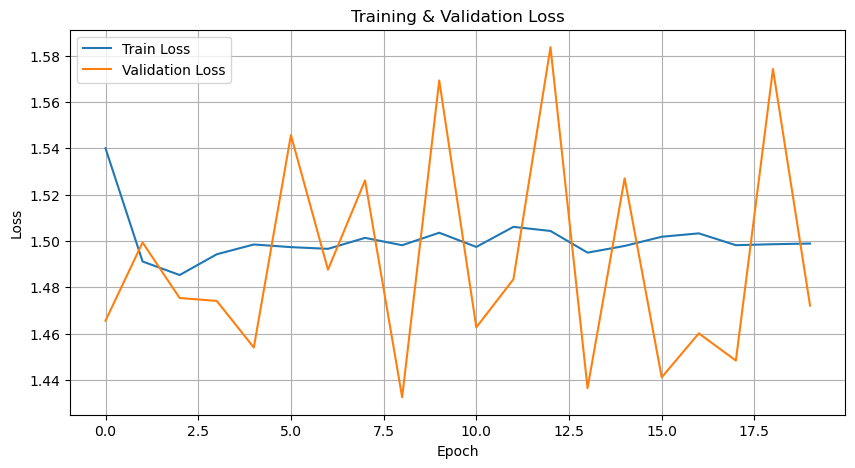

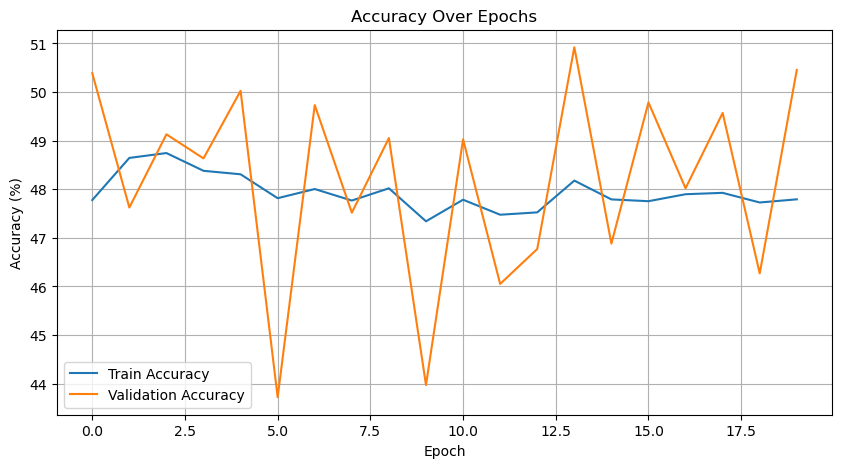

Accuracy: 50.44%
RMSE: 1.2211
RAE : 1.4910


Epoch: 100%|██████████| 20/20 [05:17<00:00, 15.86s/epoch]


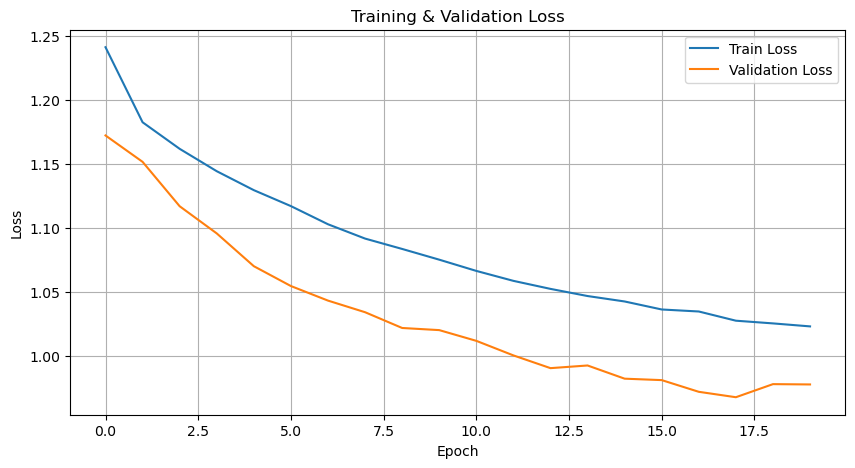

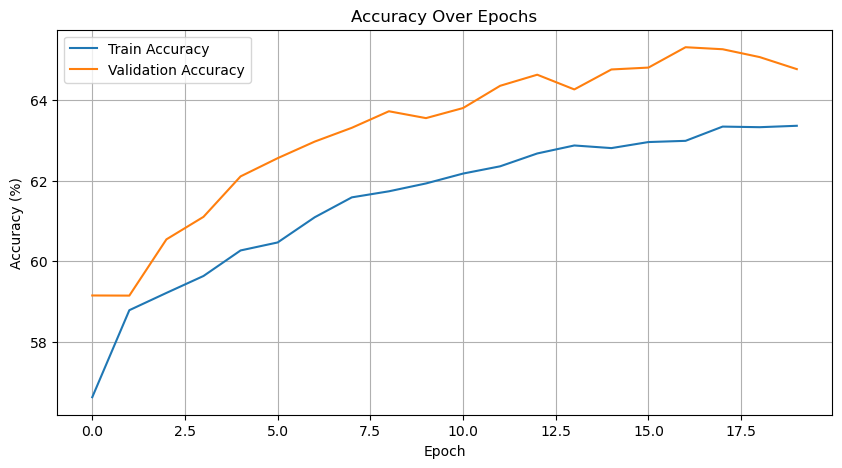

Accuracy: 55.43%
RMSE: 1.0156
RAE : 1.0315


Epoch: 100%|██████████| 20/20 [05:07<00:00, 15.37s/epoch]


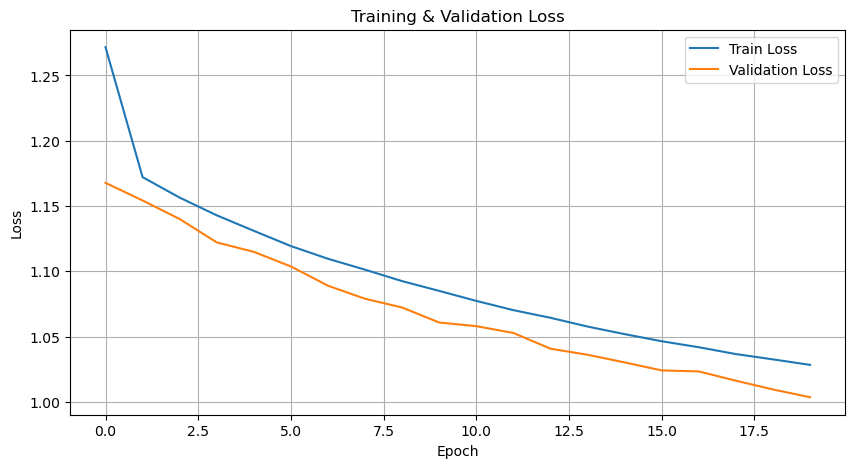

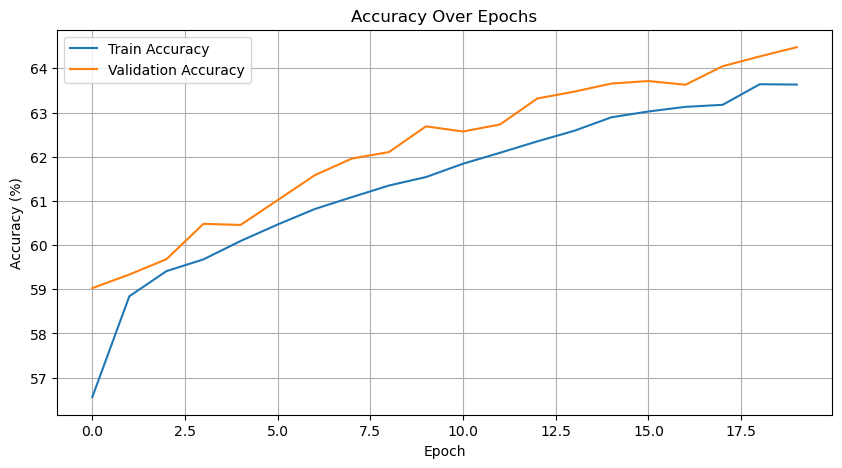

Accuracy: 59.44%
RMSE: 1.0344
RAE : 1.0699


Epoch:  85%|████████▌ | 17/20 [04:18<00:45, 15.22s/epoch]

In [ ]:
# Combination A: Learning rate = 0.1, Batch size = 16, Optimizer = Adam, Activation = ReLU, Loss = RMSE
train(0.1, 16,  train_vectors, train_labels, test_vectors, test_labels)
# Combination B: Learning rate = 0.01, Batch size = 16, Optimizer = Adam, Activation = ReLU, Loss = RMSE
train(0.01, 16,  train_vectors, train_labels, test_vectors, test_labels)
# Combination C: Learning rate = 0.001, Batch size = 16, Optimizer = Adam, Activation = ReLU, Loss = RMSE
train(0.001, 16, train_vectors, train_labels, test_vectors, test_labels)
# Combination D: Learning rate = 0.001, Batch size = 16, Optimizer = Adam, Activation = ReLU, Loss = RAE
train(0.001, 16, train_vectors, train_labels, test_vectors, test_labels)